# Load Data and Explore

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import yfinance as yf
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import scipy.stats as stats

In [2]:
portfolio_df = pd.read_excel('../data/TCI_2025_Q1_Q2.xlsx', sheet_name='Sheet1')

In [3]:
portfolio_df.head()

,Year,Quarter End,Security Type,Mkt value,Qty,ISIN,SEDOL,Coupon,Maturity,Instrument Description,Issuer,Sector,% of NAV
0,2024,4,Equity,5.719232e+09,13568759.0,US5949181045,2588173,NaN,NaN,MICROSOFT ORD (NMS),Microsoft,Technology,0.099315
1,2024,4,Equity,2.448454e+09,23698762.0,FR0000125486,B1XH026,NaN,NaN,VINCI ORD (PAR),Vinci,Infrastructure,0.042518
2,2024,4,Equity,1.700672e+09,16747485.0,CA1363751027,2180632,NaN,NaN,CANADIAN NATIONAL RAILWAY ORD (TOR),Canadian National,Railroads,0.029532
3,2024,4,Equity,7.040704e+09,42212984.0,US3696043013,BL59CR9,NaN,NaN,GE AEROSPACE ORD (NYS),GE Aerospace,Aerospace,0.122262
4,2024,4,Equity,2.665407e+09,36811965.0,CA13646K1084,BMBQR09,NaN,NaN,CANADIAN PACIFIC KANSAS CITY ORD (TOR),Canadian Pacific Kansas City,Railroads,0.046285


In [4]:
print(portfolio_df.shape)

(59, 13)


In [5]:
portfolio_df['Year Quarter Formatted'] = portfolio_df['Year'].astype(str) + '-Q' + portfolio_df['Quarter End'].astype(str)
portfolio_df['Year Quarter Date'] = pd.to_datetime(portfolio_df['Year Quarter Formatted']) + pd.offsets.QuarterEnd(0)

/tmp/ipykernel_1917040/4149915252.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  portfolio_df['Year Quarter Date'] = pd.to_datetime(portfolio_df['Year Quarter Formatted']) + pd.offsets.QuarterEnd(0)


In [6]:
portfolio_df.iloc[50:70]

,Year,Quarter End,Security Type,Mkt value,Qty,ISIN,SEDOL,Coupon,Maturity,Instrument Description,Issuer,Sector,% of NAV,Year Quarter Formatted,Year Quarter Date
50,2025,2,Equity,5.733459e+09,NaN,US6153691059,2252058,NaN,NaN,MOODYS ORD (NYS),Moody's,Financial Services,0.089216,2025-Q2,2025-06-30
51,2025,2,Equity,5.616047e+09,NaN,FR0000125486,B1XH026,NaN,NaN,VINCI ORD (PAR),Vinci,Infrastructure,0.087389,2025-Q2,2025-06-30
52,2025,2,Equity,5.085090e+09,NaN,US78409V1044,BYV2325,NaN,NaN,S&P GLOBAL ORD (NYS),S&P Global,Financial Services,0.079127,2025-Q2,2025-06-30
53,2025,2,Equity,3.725052e+09,NaN,NL0015001FS8,BRS7CF0,NaN,NaN,FERROVIAL ORD (MCE) *FER.MC,Ferrovial,Infrastructure,0.057964,2025-Q2,2025-06-30
54,2025,2,Equity,3.174044e+09,NaN,CA13646K1084,BMBQR09,NaN,NaN,CANADIAN PACIFIC KANSAS CITY ORD (TOR),Canadian Pacific Kansas City,Railroads,0.049390,2025-Q2,2025-06-30
55,2025,2,Equity,1.972997e+09,NaN,ES0105046017,BTMKJR0,NaN,NaN,AENA SME ORD (MCE),Aena,Infrastructure,0.030701,2025-Q2,2025-06-30
56,2025,2,Equity,1.812271e+09,NaN,CA1363751027,2210959,NaN,NaN,CANADIAN NATIONAL RAILWAY ORD (NYS),Canadian National,Railroads,0.028200,2025-Q2,2025-06-30
57,2025,2,Equity,1.791834e+09,NaN,ES0105066007,BX90C05,NaN,NaN,CELLNEX TELECOM SA (MCE),Cellnex Telecom SA,Communication Services,0.027882,2025-Q2,2025-06-30
58,2025,2,Equity,1.303614e+09,NaN,US02079K1079,BYY88Y7,NaN,NaN,ALPHABET CL C ORD (NMS),Alphabet,Information Technology,0.020285,2025-Q2,2025-06-30


In [7]:
# portfolio_df.to_csv('your_file_name.csv', index=False)
### Remove Short Position
portfolio_df = portfolio_df[portfolio_df['Mkt value'] > 0]

### replace ISIN number for AENA
portfolio_df.loc[portfolio_df['ISIN'] == 'ES0105046009', 'ISIN'] = 'ES0105046017'

In [8]:
security_type_count = portfolio_df.groupby('Security Type')['ISIN'].nunique()
print(security_type_count)

Security Type
Equity         16
Equity Swap     4
Name: ISIN, dtype: int64


# Portfolio Summary

In [9]:
def create_stacked_bar_chart(df: pd.DataFrame, stacked_column: str):
    """
    Generates a stacked bar chart showing the stacked_column for each ISIN per quarter.

    Args:
        df: A pandas DataFrame with the specified columns.
        stacked_column: variable header whose value to be stacked
    """
    # --- 1. Data Cleaning and Preparation ---
    # Ensure the specified column is a numeric type
    df[stacked_column] = pd.to_numeric(df[stacked_column], errors='coerce')

    # Drop any rows where the stacked_column value is missing or could not be converted
    df.dropna(subset=[stacked_column], inplace=True)
    print(df.shape)

    # --- 2. Create the stacked bar chart using Plotly Express ---
    # The x-axis is the 'Year Quarter Formatted' column
    # The y-axis is the value from the 'stacked_column'
    # The 'color' parameter stacks the bars by 'ISIN'

    fig = px.bar(
        df,
        x='Year Quarter Formatted',
        y=stacked_column,
        color='ISIN',
        title=f'Holding Weight ({stacked_column}) of Each ISIN per Quarter',
        labels={
            stacked_column: f'Value of {stacked_column}',
            'Year Quarter Formatted': 'Quarter'
        },
        hover_data={'ISIN': True, 'Issuer': True, stacked_column: ':,.2f'} # Format hover tooltip
    )

    # Customize the layout for better readability
    fig.update_layout(
        xaxis_title='Quarter',
        yaxis_title=f'Stack of ({stacked_column})',
        legend_title='ISIN',
        barmode='relative', # This ensures the bars are stacked
        yaxis=dict(
            autorange=True
        ),
        uniformtext_minsize=8, # Ensure labels are readable
        uniformtext_mode='hide', # Hide text if it doesn't fit
    )

    fig.show()


### Market Value

In [10]:
portfolio_pivot_mkt_value = pd.pivot_table(
    portfolio_df,
    values='Mkt value',
    index=['ISIN', 'Issuer'],
    columns='Year Quarter Formatted',
    aggfunc='sum'
)

In [11]:
portfolio_pivot_mkt_value

,Year Quarter Formatted,2024-Q4,2025-Q1,2025-Q2
ISIN,Issuer,,,
CA1363751027,Canadian National,2.905244e+09,2.541729e+09,1.812271e+09
CA13646K1084,Canadian Pacific Kansas City,3.656980e+09,3.545736e+09,3.174044e+09
DE0007236101,Siemens AG,6.266768e+08,NaN,NaN
ES0105046017,Aena,1.683196e+09,1.928662e+09,1.972997e+09
ES0105066007,Cellnex Telecom SA,1.798247e+09,2.020635e+09,1.791834e+09
FR0000073272,Safran,6.486485e+09,7.874975e+09,8.947476e+09
FR0000125486,Vinci,4.697191e+09,5.719506e+09,5.616047e+09
NL0000235190,Airbus,5.837015e+09,6.410428e+09,6.510550e+09
NL0015001FS8,Ferrovial,3.410462e+09,3.612298e+09,3.725052e+09


(58, 15)


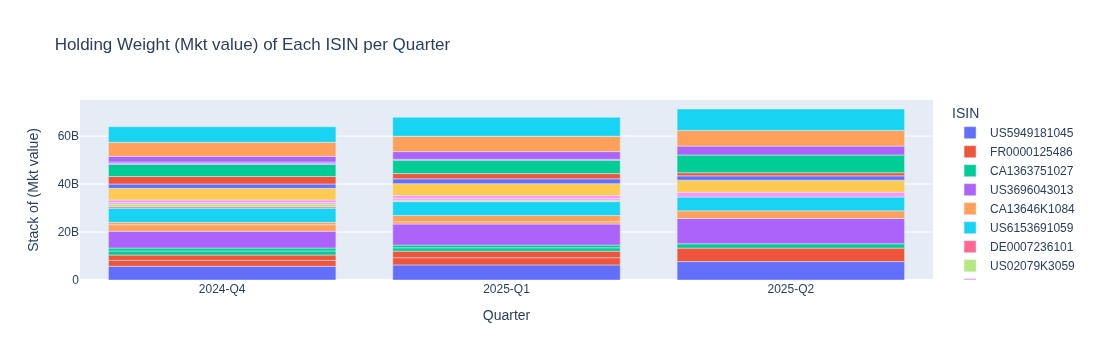

In [12]:
create_stacked_bar_chart(portfolio_df, 'Mkt value')

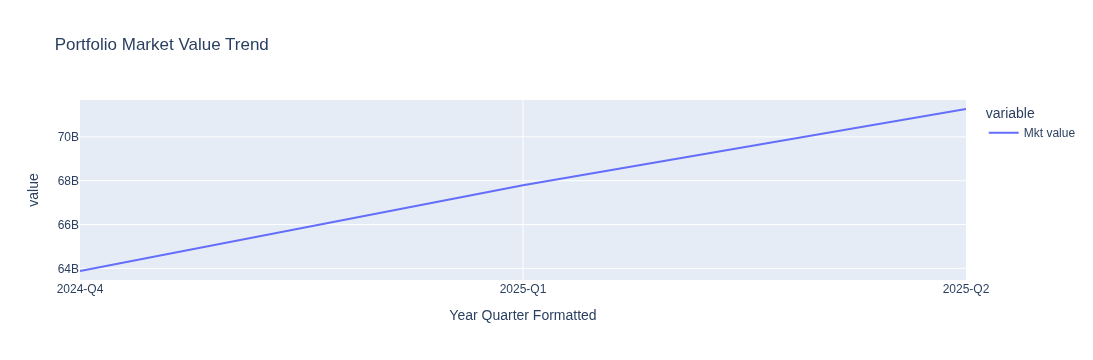

In [13]:
portfolio_value_df = portfolio_df.groupby('Year Quarter Formatted')['Mkt value'].sum().to_frame()
px.line(portfolio_value_df, title ='Portfolio Market Value Trend')


# Return, Correlation & Beta to Market 

### Unique ISIN Given Quater

In [14]:
def get_unique_isin_by_quarter(data_frame, year_quarter_formatted):
    """
    Filters the DataFrame to return a list of unique ISINs for a specified
    'Year Quarter Formatted'.
    
    Args:
        data_frame (pd.DataFrame): The input pandas DataFrame.
        year_quarter_formatted (str): The string representing the year and quarter
                                      (e.g., '2024-Q4').

    Returns:
        list: A list of unique ISINs.
    """
    quarterly_data = data_frame[data_frame['Year Quarter Formatted'] == year_quarter_formatted]
    
    unique_isins = quarterly_data['ISIN'].unique()
    
    return unique_isins.tolist()

### Daily Return Given ISIS and start_date, end_date

In [15]:
def get_daily_returns_data(isins, start_date, end_date):
    """
    Downloads daily adjusted close price data for a list of ISINs and calculates
    the daily returns.

    Note: yfinance uses tickers (e.g., MSFT, GOOGL) not ISINs. This function
    uses a simple hardcoded mapping for demonstration. In a real application,
    you would need a robust ISIN-to-ticker mapping service.

    Args:
        isins (list): A list of ISINs.
        start_date (str): The start date for the data download (YYYY-MM-DD).
        end_date (str): The end date for the data download (YYYY-MM-DD).

    Returns:
        pd.DataFrame: A DataFrame of daily returns for the given ISINs.
    """
    # Simple hardcoded mapping from ISIN to a yfinance-compatible ticker
    isin_to_ticker_map = {
        'US5949181045': 'MSFT',       # Microsoft
        'FR0000125486': 'DG.PA',      # Vinci
        'CA1363751027': 'CNI',        # Canadian National Railway
        'US3696043013': 'GE',         # GE Aerospace
        'CA13646K1084': 'CP',         # Canadian Pacific Kansas City
        'US6153691059': 'MCO',        # Moody's
        'DE0007236101': 'SIE.DE',     # Siemens AG
        'US02079K3059': 'GOOGL',      # Alphabet Cl A
        'ES0105046009': 'AENA.MC',    # Aena
        'ES0105046017': 'AENA.MC',    # Aena
        'US78409V1044': 'SPGI',       # S&P Global
        'ES0105066007': 'CLNX.MC',    # Cellnex Telecom SA
        'US02079K1079': 'GOOG',       # Alphabet Cl C
        'US92826C8394': 'V',          # Visa
        'NL0015001FS8': 'FER.MC',     # Ferrovial
        'NL0000235190': 'AIR.PA',     # Airbus
        'FR0000073272': 'SAF.PA'      # Safran
    }
    
    # Convert the list of ISINs to a list of yfinance tickers
    tickers = [isin_to_ticker_map.get(isin) for isin in isins if isin in isin_to_ticker_map]
    
    if not tickers:
        print("No valid tickers found for the given ISINs.")
        return pd.DataFrame()

    # Download adjusted close price data
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    
    # Calculate daily returns
    daily_returns = data.pct_change().dropna()
    
    # Rename columns to their original ISINs for clarity
    daily_returns = daily_returns.rename(columns={ticker: isin for isin, ticker in isin_to_ticker_map.items()})

    return daily_returns

### Portfolio Daily Return Given targert Quarter, individual stock daily return, portfolio Dataframe

In [16]:
def calculate_portfolio_daily_returns(data_frame, daily_returns_df, target_quarter):
    """
    Calculates the portfolio's daily returns based on the daily returns of
    individual securities and their market-value weights for a specific quarter.

    Args:
        data_frame (pd.DataFrame): The main DataFrame with portfolio holdings.
        daily_returns_df (pd.DataFrame): A DataFrame with individual security daily returns.
        target_quarter (str): The quarter used to determine portfolio weights (e.g., '2024-Q4').

    Returns:
        pd.Series: A Series of the portfolio's daily returns.
    """
    # Filter the main DataFrame for the specific quarter
    quarterly_holdings = data_frame[data_frame['Year Quarter Formatted'] == target_quarter]
    
    # Calculate the total market value for the quarter
    total_mkt_value = quarterly_holdings['Mkt value'].sum()
    
    # Calculate weights for each ISIN in the portfolio for that quarter
    # We use a pivot table to ensure that each ISIN has a single weight
    weights_df = quarterly_holdings.pivot_table(
        index='ISIN',
        values='Mkt value',
        aggfunc='sum'
    )
    
    # Normalize the weights to sum to 1
    weights_df['weight'] = weights_df['Mkt value'] / total_mkt_value
    
    # Create a dictionary for easy mapping from ISIN to weight
    weights = weights_df['weight'].to_dict()
    
    # Align the daily returns DataFrame with the weights
    # Reindex columns to match the order of the weights dictionary and fill any NaNs with 0
    aligned_returns = daily_returns_df[list(weights.keys())].fillna(0)
    
    # Multiply the returns by their corresponding weights and sum across columns
    # to get the portfolio daily return
    portfolio_daily_returns = aligned_returns.dot(pd.Series(weights))
    
    return portfolio_daily_returns

### 2025 Q1

In [17]:
target_quarter_q1 = '2024-Q4'
start_date_str_q1 = '2025-01-01'
end_date_str_q1 = '2025-03-31'
unique_isins_for_quarter_1 = get_unique_isin_by_quarter(portfolio_df, target_quarter_q1)
unique_isins_for_quarter_1 


['US5949181045',
 'FR0000125486',
 'CA1363751027',
 'US3696043013',
 'CA13646K1084',
 'US6153691059',
 'DE0007236101',
 'US02079K3059',
 'ES0105046017',
 'US78409V1044',
 'ES0105066007',
 'US02079K1079',
 'US92826C8394',
 'NL0015001FS8',
 'NL0000235190',
 'FR0000073272']

In [18]:
daily_returns_df_q1 = get_daily_returns_data(unique_isins_for_quarter_1, start_date_str_q1, end_date_str_q1)
portfolio_returns_q1 = calculate_portfolio_daily_returns(portfolio_df, daily_returns_df_q1, target_quarter_q1)
portfolio_returns_q1

/tmp/ipykernel_1917040/2675232800.py:47: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  16 of 16 completed
/tmp/ipykernel_1917040/2675232800.py:50: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



Date
2025-01-03    0.002601
2025-01-06    0.005381
2025-01-07   -0.002779
2025-01-08   -0.000464
2025-01-09    0.002225
                ...   
2025-03-24    0.011873
2025-03-25    0.010110
2025-03-26   -0.009028
2025-03-27   -0.003270
2025-03-28   -0.018447
Freq: B, Length: 61, dtype: float64

### SP500 Daily Return for start_date, end_date

In [19]:
def calculate_sp500_daily_returns(start_date, end_date):
    """
    Downloads daily adjusted close price data for the S&P 500 (^GSPC) and
    calculates its daily returns.

    Args:
        start_date (str): The start date for the data download (YYYY-MM-DD).
        end_date (str): The end date for the data download (YYYY-MM-DD).

    Returns:
        pd.Series: A Series of the S&P 500's daily returns.
    """
    try:
        sp500_data = yf.download('^GSPC', start=start_date, end=end_date)['Close']
        sp500_returns = sp500_data.pct_change().dropna()
        return sp500_returns
    except Exception as e:
        print(f"Error fetching S&P 500 data: {e}")
        return pd.Series()


In [20]:
def get_sh_daily_returns(start_date, end_date):
    """
    Downloads daily adjusted close price data for the SH ETF and calculates
    its daily returns.

    Args:
        start_date (str): The start date for the data download (YYYY-MM-DD).
        end_date (str): The end date for the data download (YYYY-MM-DD).

    Returns:
        pd.Series: A Series of the SH ETF's daily returns.
    """
    try:
        sh_data = yf.download('SH', start=start_date, end=end_date)['Close']
        sh_returns = sh_data.pct_change().dropna()
        return sh_returns
    except Exception as e:
        print(f"Error fetching SH data: {e}")
        return pd.Series()

In [21]:
def calculate_portfolio_beta(sp500_returns, portfolio_returns):
    """
    Calculates the portfolio's beta (exposure to the S&P 500) using linear
    regression. Beta is the slope of the regression line with the market
    returns as the independent variable (x) and the portfolio returns as
    the dependent variable (y).

    Args:
        sp500_returns (pd.Series): Daily returns of the S&P 500.
        portfolio_returns (pd.Series): Daily returns of the portfolio.

    Returns:
        float: The calculated beta value.
    """
    # Align the two Series on their common dates and drop any NaNs
    aligned_data = pd.concat([portfolio_returns, sp500_returns], axis=1).dropna()

    # Ensure there's enough data for regression
    if len(aligned_data) < 2:
        print("Not enough data to perform linear regression.")
        return None

    # Perform linear regression. The slope of this line is the beta.
    # The market returns (S&P 500) are the independent variable (x),
    # and the portfolio returns are the dependent variable (y).
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        aligned_data.iloc[:, 1], # x-axis: S&P 500 returns
        aligned_data.iloc[:, 0]  # y-axis: Portfolio returns
    )
    
    return slope

### Correlation and Beta

In [23]:
sp500_returns_q1 = calculate_sp500_daily_returns(start_date_str_q1, end_date_str_q1)
sh_returns_q1 = get_sh_daily_returns(start_date_str_q1, end_date_str_q1)
aligned_data_q1 = pd.concat([portfolio_returns_q1, sp500_returns_q1, sh_returns_q1], axis=1).dropna()
print(aligned_data_q1.shape)
correlation_q1 = aligned_data_q1.iloc[:, 0].corr(aligned_data_q1.iloc[:, 1])
correlation_q1

/tmp/ipykernel_1917040/3650545756.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1917040/369439858.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

(58, 3)


np.float64(0.8427266529879857)

In [24]:
beta_q1 = calculate_portfolio_beta(sp500_returns_q1, portfolio_returns_q1)
beta_q1

np.float64(0.7752497925705368)

# Simulate adding SH into Portfolio

In [25]:
def simulate_portfolio_with_sh_etf(beta_requirement, sp500_returns, portfolio_returns, start_date, end_date):
    """
    Simulates adding a short S&P 500 ETF (SH) to a portfolio to achieve a target beta.

    Args:
        beta_requirement (float): The desired beta for the new portfolio.
        sp500_returns (pd.Series): The daily returns of the S&P 500.
        portfolio_returns (pd.Series): The daily returns of the original portfolio.
        start_date (str): The start date for data fetching.
        end_date (str): The end date for data fetching.

    Returns:
        dict: A dictionary with the simulation results, including weights,
              returns, and correlations.
    """
    # 1. Get the SH ETF daily returns
    try:
        sh_returns = yf.download('SH', start=start_date, end=end_date)['Close'].pct_change().dropna()
    except Exception as e:
        print(f"Error fetching SH data: {e}")
        return {}

    # 2. Align all returns data to the same dates
    aligned_returns = pd.concat([portfolio_returns, sh_returns, sp500_returns], axis=1).dropna()
    aligned_portfolio_returns = aligned_returns.iloc[:, 0]
    aligned_sh_returns = aligned_returns.iloc[:, 1]
    aligned_sp500_returns = aligned_returns.iloc[:, 2]

    if len(aligned_returns) < 2:
        print("Not enough aligned data to perform simulation.")
        return {}
    
    # 3. Calculate metrics for the original portfolio
    beta_orig = calculate_portfolio_beta(aligned_sp500_returns, aligned_portfolio_returns)
    corr_orig = aligned_portfolio_returns.corr(aligned_sp500_returns)
    # The number of trading days in a year is approximately 252
    annualized_return_orig = (1 + aligned_portfolio_returns.mean())**252 - 1

    # 4. Calculate the beta of the SH ETF
    beta_sh = calculate_portfolio_beta(aligned_sp500_returns, aligned_sh_returns)
    if beta_sh is None:
        return {}
    
    # 5. Calculate the weight of SH needed to meet the beta requirement
    if beta_sh - beta_orig == 0:
        print("Cannot calculate SH weight. Original portfolio beta is too close to SH beta.")
        return {}
    
    sh_weight = (beta_requirement - beta_orig) / (beta_sh - beta_orig)
    
    if not (0 <= sh_weight <= 1):
        print(f"Warning: Calculated SH weight ({sh_weight:.4f}) is outside the valid range (0-1). Beta requirement may be unachievable with a long-only position.")
        # We can still proceed with the calculation for demonstration purposes
    
    # 6. Calculate new portfolio returns, annualized return, and correlation
    new_portfolio_returns = (aligned_portfolio_returns * (1 - sh_weight)) + (aligned_sh_returns * sh_weight)
    
    new_annualized_return = (1 + new_portfolio_returns.mean())**252 - 1
    new_correlation = new_portfolio_returns.corr(aligned_sp500_returns)
    
    # 7. Return the results
    return {
        "sh_weight": sh_weight,
        "annualized_return_orig": annualized_return_orig,
        "annualized_return_new": new_annualized_return,
        "correlation_orig": corr_orig,
        "correlation_new": new_correlation
    }

In [26]:
beta_target_q1 = 0.5 
simulation_results_q1 = simulate_portfolio_with_sh_etf(
        beta_target_q1, 
        sp500_returns_q1, 
        portfolio_returns_q1, 
        start_date_str_q1, 
        end_date_str_q1
    )
print(f"Target Beta: {beta_target_q1}")
print(f"Weight of SH ETF in new portfolio: {simulation_results_q1['sh_weight']:.4f}")
print(f"Original Annualized Portfolio Return: {simulation_results_q1['annualized_return_orig']:.2%}")
print(f"New Annualized Portfolio Return (with SH): {simulation_results_q1['annualized_return_new']:.2%}")
print(f"Original Correlation with S&P 500: {simulation_results_q1['correlation_orig']:.4f}")
print(f"New Correlation with S&P 500: {simulation_results_q1['correlation_new']:.4f}")

/tmp/ipykernel_1917040/1264555716.py:18: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Target Beta: 0.5
Weight of SH ETF in new portfolio: 0.1563
Original Annualized Portfolio Return: 15.80%
New Annualized Portfolio Return (with SH): 18.15%
Original Correlation with S&P 500: 0.8427
New Correlation with S&P 500: 0.7691


# Repeat on 2025 Q2

In [27]:
target_quarter_q2 = '2025-Q1'
start_date_str_q2 = '2025-04-01'
end_date_str_q2 = '2025-06-30'
unique_isins_for_quarter_2 = get_unique_isin_by_quarter(portfolio_df, target_quarter_q2)
unique_isins_for_quarter_2


['US5949181045',
 'CA1363751027',
 'FR0000125486',
 'CA13646K1084',
 'US6153691059',
 'US3696043013',
 'ES0105046017',
 'US02079K3059',
 'ES0105066007',
 'US78409V1044',
 'US02079K1079',
 'US92826C8394',
 'NL0015001FS8',
 'NL0000235190',
 'FR0000073272']

In [28]:
daily_returns_df_q2 = get_daily_returns_data(unique_isins_for_quarter_2, start_date_str_q2, end_date_str_q2)
portfolio_returns_q2 = calculate_portfolio_daily_returns(portfolio_df, daily_returns_df_q2, target_quarter_q2)
portfolio_returns_q2

/tmp/ipykernel_1917040/2675232800.py:47: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  15 of 15 completed
/tmp/ipykernel_1917040/2675232800.py:50: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



Date
2025-04-02   -0.001648
2025-04-03   -0.031758
2025-04-04   -0.062600
2025-04-07   -0.030516
2025-04-08    0.009405
                ...   
2025-06-23    0.009070
2025-06-24    0.012919
2025-06-25   -0.001626
2025-06-26    0.007883
2025-06-27    0.008539
Length: 62, dtype: float64

In [29]:
sp500_returns_q2= calculate_sp500_daily_returns(start_date_str_q2, end_date_str_q2)
sh_returns_q2 = get_sh_daily_returns(start_date_str_q2, end_date_str_q2)
aligned_data_q2 = pd.concat([portfolio_returns_q2, sp500_returns_q2, sh_returns_q2], axis=1).dropna()
print(aligned_data_q2.shape)
correlation_q2 = aligned_data_q2.iloc[:, 0].corr(aligned_data_q2.iloc[:, 1])
correlation_q2

/tmp/ipykernel_1917040/3650545756.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1917040/369439858.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

(60, 3)


np.float64(0.7498459906794822)

In [30]:
beta_q2 = calculate_portfolio_beta(sp500_returns_q2, portfolio_returns_q2)
beta_q2

np.float64(0.5692927748524316)

In [31]:
beta_target_q2 = 0.5
simulation_results_q2 = simulate_portfolio_with_sh_etf(
        beta_target_q2, 
        sp500_returns_q2, 
        portfolio_returns_q2, 
        start_date_str_q2, 
        end_date_str_q2
    )
print(f"Target Beta: {beta_target_q2}")
print(f"Weight of SH ETF in new portfolio: {simulation_results_q2['sh_weight']:.4f}")
print(f"Original Annualized Portfolio Return: {simulation_results_q2['annualized_return_orig']:.2%}")
print(f"New Annualized Portfolio Return (with SH): {simulation_results_q2['annualized_return_new']:.2%}")
print(f"Original Correlation with S&P 500: {simulation_results_q2['correlation_orig']:.4f}")
print(f"New Correlation with S&P 500: {simulation_results_q2['correlation_new']:.4f}")

/tmp/ipykernel_1917040/1264555716.py:18: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Target Beta: 0.5
Weight of SH ETF in new portfolio: 0.0444
Original Annualized Portfolio Return: 47.65%
New Annualized Portfolio Return (with SH): 42.80%
Original Correlation with S&P 500: 0.7498
New Correlation with S&P 500: 0.7215


# Return Plot - Portfolio, SP500, Portfolio + x% SH

In [32]:
aligned_data_q1_q2 = pd.concat([aligned_data_q1, aligned_data_q2], axis=0)
aligned_data_q1_q2.columns = ['Portfolio', 'SP500', 'SH']
aligned_data_q1_q2

,Portfolio,SP500,SH
Date,,,
2025-01-03,0.002601,0.012596,-0.011765
2025-01-06,0.005381,0.005538,-0.005714
2025-01-07,-0.002779,-0.011104,0.011015
2025-01-08,-0.000464,0.001560,-0.000474
2025-01-10,-0.014511,-0.015412,0.015640
...,...,...,...
2025-06-23,0.009070,0.009607,-0.009846
2025-06-24,0.012919,0.011122,-0.011157
2025-06-25,-0.001626,-0.000003,-0.000297


In [33]:
def calculate_correlations_with_sh_etf(aligned_returns, sh_weight):
    """
    Calculates the original and new portfolio returns after adding a specified
    weight of the SH ETF. It then returns a DataFrame containing all relevant
    daily return series.

    Args:
        aligned_returns (pd.DataFrame): A DataFrame with the aligned daily returns
                                        of the original portfolio, SH ETF, and S&P 500.
        sh_weight (float): The weight of the SH ETF in the new portfolio.

    Returns:
        pd.DataFrame: A DataFrame with columns for 'Original Portfolio Returns',
                      'S&P 500 Returns', 'SH ETF Returns', and 'New Portfolio Returns'.
    """
    # Extract the returns from the aligned DataFrame
    original_portfolio_returns = aligned_returns['Portfolio']
    sh_returns = aligned_returns['SH']
    sp500_returns = aligned_returns['SP500']

    # Calculate the new portfolio returns
    new_portfolio_returns = (original_portfolio_returns * (1 - sh_weight)) + (sh_returns * sh_weight)

    # Create a new DataFrame with all the return series
    results_df = pd.DataFrame({
        'Portfolio': original_portfolio_returns,
        'SP500': sp500_returns,
        'Portfolio + SH': new_portfolio_returns
    })

    corr_orig = original_portfolio_returns.corr(sp500_returns)
    new_correlation = new_portfolio_returns.corr(sp500_returns)
    
    return results_df, corr_orig, new_correlation

In [34]:
def plot_cumulative_returns(portfolio_1_q1_q2, sp500_returns_q1_q2, portfolio_2_q1_q2, 
                          title="Cumulative Returns Comparison"):
    """
    Plot cumulative returns for three return series using plotly.express
    
    Parameters:
    portfolio_1_q1_q2: pandas Series with daily returns for Portfolio 1
    sp500_returns_q1_q2: pandas Series with daily returns for S&P 500
    portfolio_2_q1_q2: pandas Series with daily returns for Portfolio 2
    title: string, title for the plot
    
    Returns:
    plotly figure object
    """
    
    # Calculate cumulative returns (1 + return).cumprod() - 1
    # This gives cumulative return from initial investment
    portfolio_1_cum = (1 + portfolio_1_q1_q2).cumprod() - 1
    sp500_cum = (1 + sp500_returns_q1_q2).cumprod() - 1
    portfolio_2_cum = (1 + portfolio_2_q1_q2).cumprod() - 1
    
    # Create DataFrame for plotting
    df_plot = pd.DataFrame({
        'Date': portfolio_1_cum.index,
        'Portfolio': portfolio_1_cum.values,
        'S&P 500': sp500_cum.values,
        'Portfolio + SH': portfolio_2_cum.values
    })
    
    # Melt DataFrame to long format for plotly
    df_melted = df_plot.melt(id_vars=['Date'], 
                           value_vars=['Portfolio', 'S&P 500', 'Portfolio + SH'],
                           var_name='Asset', 
                           value_name='Cumulative Return')
    
    # Create line plot
    fig = px.line(df_melted, 
                  x='Date', 
                  y='Cumulative Return',
                  color='Asset',
                  title=title,
                  labels={'Cumulative Return': 'Cumulative Return (%)',
                         'Date': 'Date'},
                  template='plotly_white')
    
    # Format y-axis as percentage
    fig.update_layout(
        yaxis_tickformat='.1%',
        hovermode='x unified',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    # Update hover template
    fig.update_traces(hovertemplate='<b>%{fullData.name}</b><br>' +
                                   'Date: %{x}<br>' +
                                   'Cumulative Return: %{y:.2%}<br>' +
                                   '<extra></extra>')
    fig.show()

In [36]:
sh_weight = 0.1
results_df, corr_orig, new_correlation = calculate_correlations_with_sh_etf(aligned_data_q1_q2, sh_weight)
print(f"Original Correlation with S&P 500: {corr_orig:.4f}")
print(f"New Correlation with S&P 500: {new_correlation:.4f}")
results_df.to_csv('daily_return.csv', index=False)

Original Correlation with S&P 500: 0.7707
New Correlation with S&P 500: 0.7048


(            Portfolio     SP500  Portfolio + SH
 Date                                           
 2025-01-03   0.002601  0.012596        0.001165
 2025-01-06   0.005381  0.005538        0.004272
 2025-01-07  -0.002779 -0.011104       -0.001400
 2025-01-08  -0.000464  0.001560       -0.000465
 2025-01-10  -0.014511 -0.015412       -0.011496
 ...               ...       ...             ...
 2025-06-23   0.009070  0.009607        0.007178
 2025-06-24   0.012919  0.011122        0.010511
 2025-06-25  -0.001626 -0.000003       -0.001493
 2025-06-26   0.007883  0.008020        0.006326
 2025-06-27   0.008539  0.005219        0.007285
 
 [118 rows x 3 columns],)

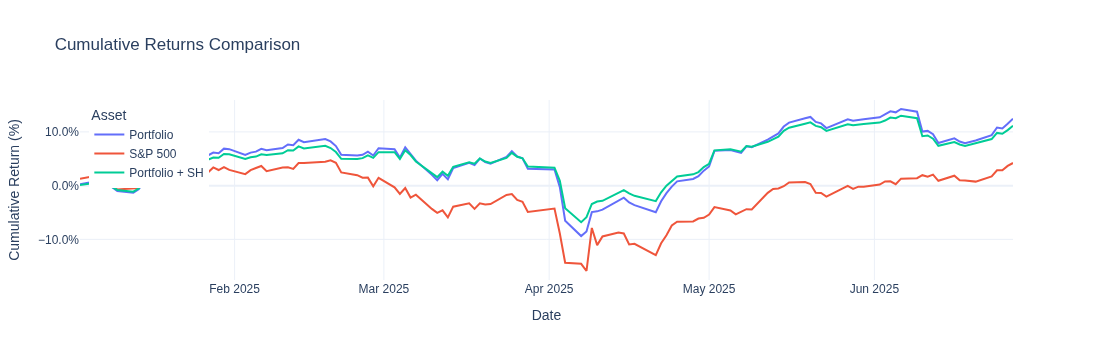

In [37]:
plot_cumulative_returns(results_df['Portfolio'], results_df['SP500'], results_df['Portfolio + SH'])